In [ ]:
# 1. Sentiment Classification (Fine-Grained Analysis)
# Use Case: Classifying emotions or nuanced sentiments beyond just positive/negative (e.g., joy, anger, sadness).
# Dataset: GoEmotions (27 fine-grained emotions).
# Evaluation: Fine-tune BERT on emotion-specific labels and compare F1 scores and confusion matrix with the pre-trained model’s performance, especially on emotions that are harder to distinguish.

In [1]:
!pip install datasets accelerate transformers torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.0 MB/s eta 0:00:00


In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, BertForSequenceClassification
from datasets import load_dataset
import numpy as np
from accelerate import Accelerator
import torch
from sklearn.metrics import f1_score, confusion_matrix

accelerator = Accelerator()

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, BertForSequenceClassification
from datasets import load_dataset
import numpy as np
import torch
from sklearn.metrics import f1_score, confusion_matrix

# Data Preparation
def convert_to_multi_hot(labels, num_labels=28):
    """Convert label indices to multi-hot encoding"""
    multi_hot = torch.zeros(num_labels, dtype=torch.float32)
    if isinstance(labels, list):
        for label in labels:
            if isinstance(label, (int, np.integer)):
                multi_hot[label] = 1.0
    return multi_hot.numpy()

def my_tokens(my_data):
    # Convert labels to multi-hot encoding
    labels = [convert_to_multi_hot(label) for label in my_data['labels']]

    # Tokenize the text
    tokenized_data = tokenizer(
        my_data['text'],
        padding=True,
        truncation=True,
        max_length=128
    )

    # Add labels to tokenized data
    tokenized_data['labels'] = labels
    return tokenized_data

# Custom data collator
class MultiLabelDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, features):
        batch = self.tokenizer.pad(
            {'input_ids': [f['input_ids'] for f in features],
             'attention_mask': [f['attention_mask'] for f in features]},
            return_tensors="pt"
        )

        # Convert labels to tensor and ensure float32 type
        if 'labels' in features[0]:
            batch['labels'] = torch.tensor([f['labels'] for f in features], dtype=torch.float32)

        return batch

# Load dataset
my_data = load_dataset("google-research-datasets/go_emotions", "simplified")

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=28,
    problem_type="multi_label_classification"
)

# Tokenize and prepare dataset
my_tokenized_data = my_data.map(
    my_tokens,
    batched=True,
    remove_columns=['id', 'text']
)

# Define metrics for evaluation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Apply sigmoid and threshold
    predictions = (torch.sigmoid(torch.tensor(predictions)) > 0.5).numpy().astype(int)

    # Calculate macro F1 score
    macro_f1 = f1_score(labels, predictions, average='macro', zero_division=1)

    return {
        'macro_f1': macro_f1
    }

# Use custom data collator
data_collator = MultiLabelDataCollator(tokenizer)

# Training arguments
training_args = TrainingArguments(
    output_dir="sentiment_classification_transformers",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    logging_steps=100,
    report_to="wandb"  # Comment this out if you don't want to use wandb
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=my_tokenized_data['train'],
    eval_dataset=my_tokenized_data['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Save the model
trainer.save_model("final_model")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.40k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/350k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Macro F1
1,0.093000,0.092392,0.269211
2,0.082400,0.085482,0.387696
3,0.074300,0.085449,0.403116


In [3]:
# using accelerate

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, BertForSequenceClassification
from datasets import load_dataset
import numpy as np
import torch
from sklearn.metrics import f1_score, confusion_matrix

# Data Preparation
def convert_to_multi_hot(labels, num_labels=28):
    """Convert label indices to multi-hot encoding"""
    multi_hot = torch.zeros(num_labels, dtype=torch.float32)
    if isinstance(labels, list):
        for label in labels:
            if isinstance(label, (int, np.integer)):
                multi_hot[label] = 1.0
    return multi_hot.numpy()

def my_tokens(my_data):
    # Convert labels to multi-hot encoding
    labels = [convert_to_multi_hot(label) for label in my_data['labels']]

    # Tokenize the text
    tokenized_data = tokenizer(
        my_data['text'],
        padding=True,
        truncation=True,
        max_length=128
    )

    # Add labels to tokenized data
    tokenized_data['labels'] = labels
    return tokenized_data

# Custom data collator
class MultiLabelDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, features):
        batch = self.tokenizer.pad(
            {'input_ids': [f['input_ids'] for f in features],
             'attention_mask': [f['attention_mask'] for f in features]},
            return_tensors="pt"
        )

        # Convert labels to tensor and ensure float32 type
        if 'labels' in features[0]:
            batch['labels'] = torch.tensor([f['labels'] for f in features], dtype=torch.float32)

        return batch

# Load dataset
my_data = load_dataset("google-research-datasets/go_emotions", "simplified")

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=28,
    problem_type="multi_label_classification"
)

model = accelerator.prepare(model)

# Tokenize and prepare dataset
my_tokenized_data = my_data.map(
    my_tokens,
    batched=True,
    remove_columns=['id', 'text']
)

my_tokenized_data = accelerator.prepare(my_tokenized_data)
train_dataset = accelerator.prepare(my_tokenized_data['train'])
eval_dataset = accelerator.prepare(my_tokenized_data['validation'])

# Define metrics for evaluation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Apply sigmoid and threshold
    predictions = (torch.sigmoid(torch.tensor(predictions)) > 0.5).numpy().astype(int)

    # Calculate macro F1 score
    macro_f1 = f1_score(labels, predictions, average='macro', zero_division=1)

    return {
        'macro_f1': macro_f1
    }

# Use custom data collator
data_collator = MultiLabelDataCollator(tokenizer)

# Training arguments
training_args = TrainingArguments(
    output_dir="sentiment_classification_transformers",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    logging_steps=100,
    report_to="wandb"  # Comment this out if you don't want to use wandb
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer = accelerator.prepare(trainer)

# Train the model
trainer.train()

# Save the model
trainer.save_model("final_model")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.40k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/350k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Macro F1
1,0.092300,0.091579,0.276568
2,0.081800,0.084579,0.390506
3,0.071100,0.085121,0.425186
4,0.061200,0.088628,0.451610
5,0.052500,0.090687,0.448541


In [ ]:
# This is for single label

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.40k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/350k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.490100,1.414826,0.575562,0.552986
2,1.209200,1.373031,0.582750,0.573378
3,0.984900,1.393295,0.590122,0.579395



Test Results: {'eval_loss': 1.3890808820724487, 'eval_accuracy': 0.5802469135802469, 'eval_f1': 0.57162623731742, 'eval_runtime': 18.7947, 'eval_samples_per_second': 288.752, 'eval_steps_per_second': 18.09, 'epoch': 3.0}


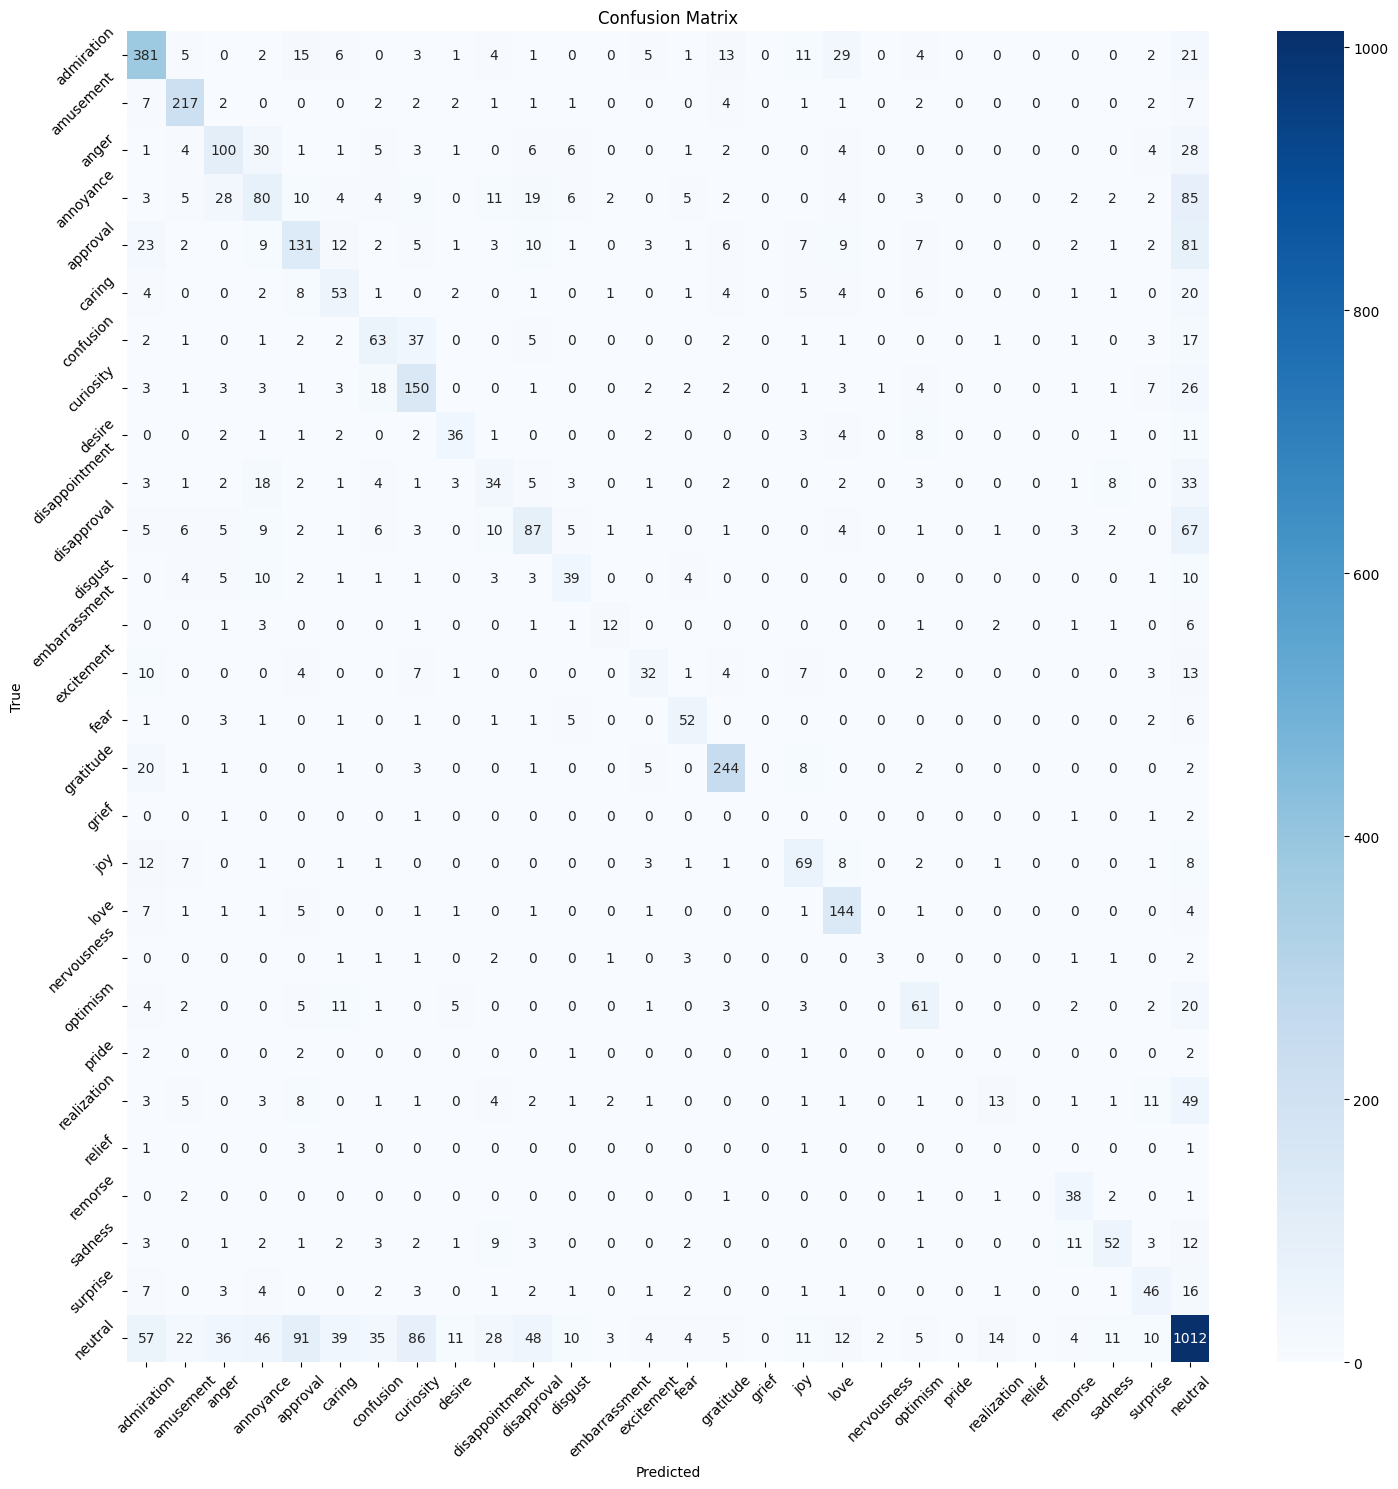

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [1]:
# Install required packages
!pip install transformers datasets evaluate numpy torch

import numpy as np
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from evaluate import load
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
dataset = load_dataset("go_emotions")

# Load tokenizer
model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Preprocess function
def preprocess_function(examples):
    # Take only the first label for each example (simplified approach)
    labels = [label[0] if len(label) > 0 else 0 for label in examples["labels"]]

    # Tokenize the texts
    tokenized = tokenizer(
        examples["text"],
        truncation=True,
        padding=True,
        max_length=128
    )

    # Add labels
    tokenized["labels"] = labels

    return tokenized

# Tokenize datasets
tokenized_datasets = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=dataset["train"].column_names
)

# Get label names for metrics
label_names = dataset["train"].features["labels"].feature.names

# Define metrics computation function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Load accuracy metric
    accuracy_metric = load("accuracy")
    f1_metric = load("f1")

    # Calculate metrics
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')

    # Calculate confusion matrix
    cm = confusion_matrix(labels, predictions)

    return {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"],
    }

# Initialize model
num_labels = len(label_names)
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_labels
)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./emotion-classifier",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
)

# Train the model
trainer.train()

# Evaluate on test set
test_results = trainer.evaluate(tokenized_datasets["test"])
print("\nTest Results:", test_results)

# Get predictions for confusion matrix
test_predictions = trainer.predict(tokenized_datasets["test"])
predictions = np.argmax(test_predictions.predictions, axis=1)
true_labels = test_predictions.label_ids

# Create confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_names,
    yticklabels=label_names
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Save the model and tokenizer
model_path = "./emotion-classifier-final"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

# Example of how to use the model for inference
def predict_emotion(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.softmax(outputs.logits, dim=-1)
        predicted_label = torch.argmax(predictions).item()

    # Get the predicted emotion label
    emotion = label_names[predicted_label]
    confidence = predictions[0][predicted_label].item()

    return {
        "emotion": emotion,
        "confidence": confidence,
        "all_probabilities": {
            label_names[i]: prob.item()
            for i, prob in enumerate(predictions[0])
        }
    }

# Example usage
example_text = "I'm really excited about this new project!"
prediction = predict_emotion(example_text)
print("\nExample Prediction:")
print(f"Text: {example_text}")
print(f"Predicted Emotion: {prediction['emotion']}")
print(f"Confidence: {prediction['confidence']:.2f}")
print("\nTop 3 emotions:")
sorted_emotions = sorted(
    prediction['all_probabilities'].items(),
    key=lambda x: x[1],
    reverse=True
)[:3]
for emotion, prob in sorted_emotions:
    print(f"{emotion}: {prob:.3f}")